<a href="https://colab.research.google.com/github/AymanNasser/Random-DNN-Notebooks/blob/master/Horse_to_Zebra_using_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading data from kaggle**

In [1]:
!pip install kaggle

## Mount the drive to colab notebook


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import json
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

## Changing directory 

In [8]:
%cd /content/gdrive/My Drive/Kaggle
%pwd

/content/gdrive/My Drive/Kaggle


'/content/gdrive/My Drive/Kaggle'

## Downloading the dataset

In [9]:
!kaggle datasets download -d arnaud58/horse2zebra
%ls

 96% 107M/111M [00:01<00:00, 104MB/s]  
100% 111M/111M [00:01<00:00, 95.9MB/s]
horse2zebra.zip  kaggle.json


## Unzipping data

In [10]:
!unzip \*.zip && rm *.zip

Archive:  horse2zebra.zip
  inflating: horse2zebra/testA/n02381460_1000.jpg  
  inflating: horse2zebra/testA/n02381460_1010.jpg  
  inflating: horse2zebra/testA/n02381460_1030.jpg  
  inflating: horse2zebra/testA/n02381460_1090.jpg  
  inflating: horse2zebra/testA/n02381460_1100.jpg  
  inflating: horse2zebra/testA/n02381460_1110.jpg  
  inflating: horse2zebra/testA/n02381460_1120.jpg  
  inflating: horse2zebra/testA/n02381460_1160.jpg  
  inflating: horse2zebra/testA/n02381460_120.jpg  
  inflating: horse2zebra/testA/n02381460_1210.jpg  
  inflating: horse2zebra/testA/n02381460_1260.jpg  
  inflating: horse2zebra/testA/n02381460_1300.jpg  
  inflating: horse2zebra/testA/n02381460_1350.jpg  
  inflating: horse2zebra/testA/n02381460_1360.jpg  
  inflating: horse2zebra/testA/n02381460_140.jpg  
  inflating: horse2zebra/testA/n02381460_1420.jpg  
  inflating: horse2zebra/testA/n02381460_1540.jpg  
  inflating: horse2zebra/testA/n02381460_1620.jpg  
  inflating: horse2zebra/testA/n02381460

# **Implementaion**

In [13]:
import numpy as np
import torch
import torch.nn as nn

## Resnet Class

In [14]:
class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


In [15]:


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [16]:
netG = ResNetGenerator()

## Loading weights

In [26]:
model_path = '/content/gdrive/My Drive/Kaggle/horse2zebra/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

## Putting the network into eval mode 

In [27]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

## Preprocessing phase

In [28]:
from PIL import Image
from torchvision import transforms

In [29]:
preprocess_pipeline = transforms.Compose([
                                          transforms.Resize(256),
                                          transforms.ToTensor()
                                          ])

/


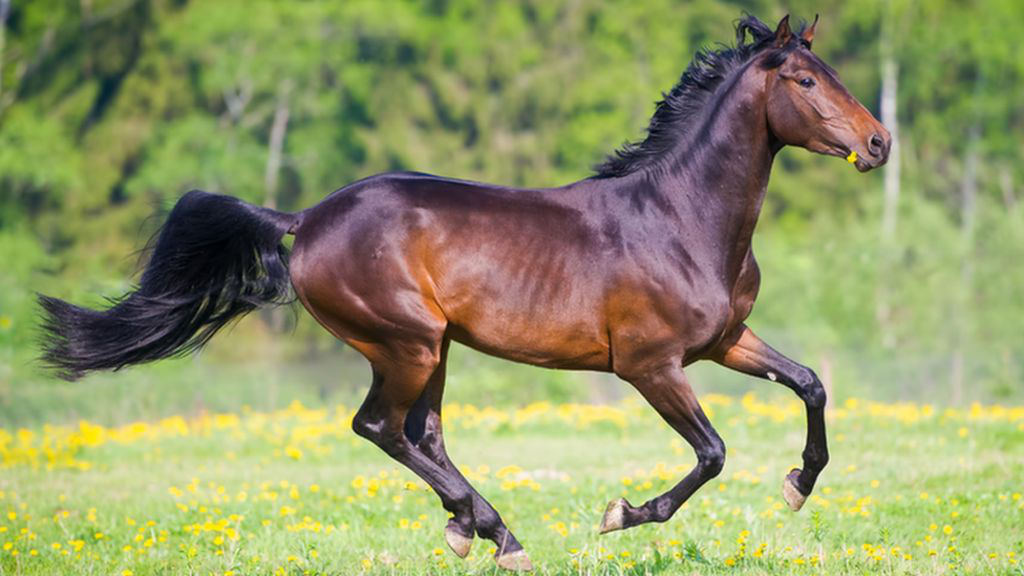

In [31]:
%cd /
img = Image.open('../tmp/Horse.png')
img

In [32]:
img_t = preprocess_pipeline(img)
batch_t = torch.unsqueeze(img_t, 0)
batch_out = netG(batch_t)

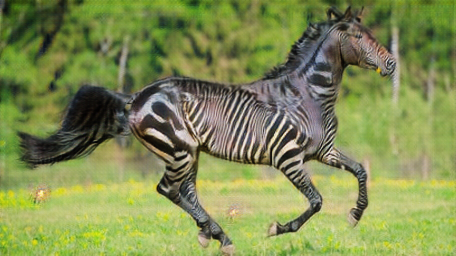

In [33]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img 

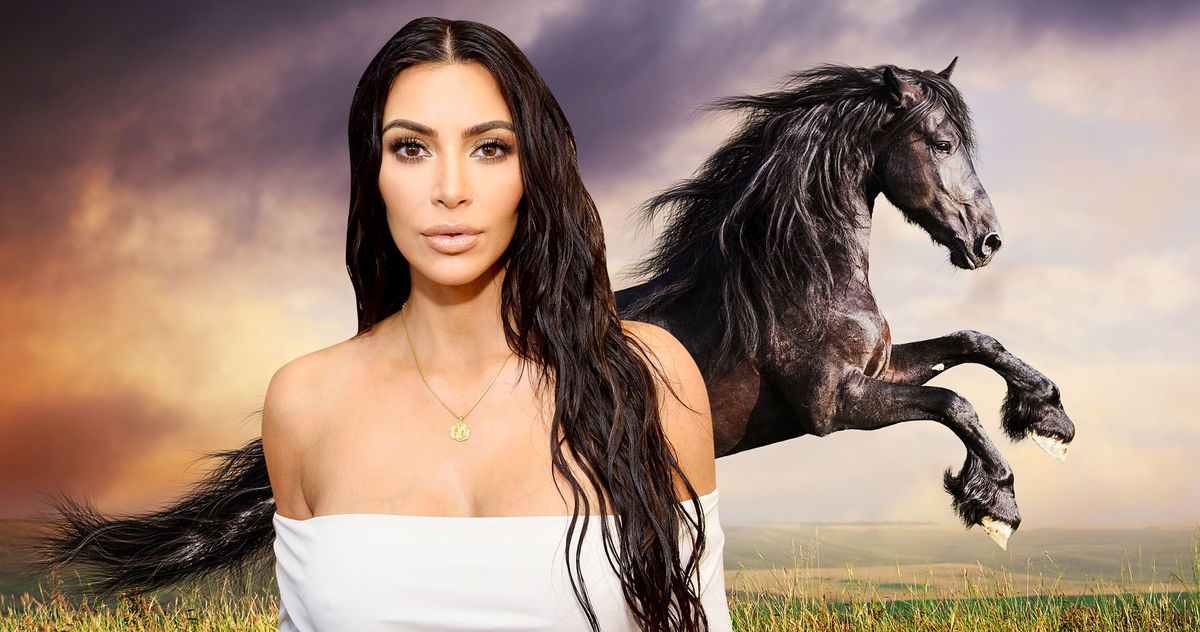

In [40]:
img = Image.open('../tmp/horse2.jpg')
img

In [41]:
img_t = preprocess_pipeline(img)
batch_t = torch.unsqueeze(img_t, 0)
batch_out = netG(batch_t)

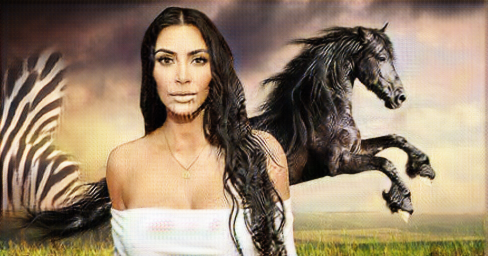

In [42]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img # Complex img ==> GAN mis-leaded !!